<a href="https://colab.research.google.com/github/TaqiyahNabila/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q google-play-scraper
!pip install -q nltk
!pip install -q wordcloud
!pip install -q matplotlib

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 603.6 kB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from google_play_scraper import Sort, reviews
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import pandas as pd

In [30]:
# Define functions here (scrape_reviews, preprocess, analyze_and_categorize, etc.)
# Scrape reviews function
def scrape_reviews(app_id, count=1000):
    all_reviews = []
    cursor = None
    while len(all_reviews) < count:
        batch, cursor = reviews(
            app_id,
            lang='id',
            country='id',
            sort=Sort.NEWEST,
            count=min(100, count - len(all_reviews)),
            continuation_token=cursor
        )
        all_reviews.extend(batch)
        if cursor is None:
            break
    return all_reviews[:count]



In [31]:
# Preprocessing: Remove stopwords, punctuation
ind_stopwords = set(stopwords.words('indonesian'))
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    words = text.split()
    words = [w for w in words if w not in ind_stopwords and len(w) > 2]
    return words



In [32]:
# Complaint categories
complaint_categories = {
    'Pengiriman Lambat': ['lama', 'lambat', 'terlambat', 'delay', 'keterlambatan', 'belum sampai'],
    'Layanan Pelanggan Buruk': ['pelanggan', 'cs', 'customer', 'layanan', 'respon', 'balasan', 'staff'],
    'Aplikasi Bermasalah': ['aplikasi', 'error', 'crash', 'bug', 'gagal', 'buka'],
    'Pengambilan Paket Sulit': ['ambil', 'pengambilan', 'sulit', 'susah', 'antrian', 'mengantri'],
    'Harga atau Biaya Mahal': ['harga', 'biaya', 'mahal', 'tarif', 'ongkos'],
    'Informasi Tidak Jelas': ['info', 'informasi', 'kurang', 'jelas', 'bingung', 'tracking']
}



In [33]:
# Analyze sentiment and categorize complaints
def analyze_and_categorize(reviews_list):
    sia = SentimentIntensityAnalyzer()
    data = []
    for rev in reviews_list:
        text = rev['content']
        sentiment = sia.polarity_scores(text)
        label = 'neutral'
        if sentiment['compound'] >= 0.05:
            label = 'positive'
        elif sentiment['compound'] <= -0.05:
            label = 'negative'
        data.append({'review': text, 'score': sentiment['compound'], 'label': label, 'at': rev['at']})
    df = pd.DataFrame(data)



In [49]:
# Analyze sentiment and categorize complaints
def analyze_and_categorize(reviews_list):
    sia = SentimentIntensityAnalyzer()
    data = []
    for rev in reviews_list:
        text = rev['content']
        sentiment = sia.polarity_scores(text)
        label = 'neutral'
        if sentiment['compound'] >= 0.05:
            label = 'positive'
        elif sentiment['compound'] <= -0.05:
            label = 'negative'
        data.append({'review': text, 'score': sentiment['compound'], 'label': label, 'at': rev['at']})
    df = pd.DataFrame(data)

    # Extract negative comments
    negative_reviews = df[df['label'] == 'negative']['review'].tolist()
    all_neg_words = []
    for comment in negative_reviews:
        all_neg_words.extend(preprocess(comment))

    # Count complaints
    complaint_counts = {}
    for cat, keywords in complaint_categories.items():
        count = 0
        for kw in keywords:
            count += all_neg_words.count(kw)
        if count > 0:
            complaint_counts[cat] = count
    complaint_counts = dict(sorted(complaint_counts.items(), key=lambda x: x[1], reverse=True))
    return df, complaint_counts, all_neg_words

In [50]:
# Plotting complaint summary bar chart
def plot_complaints(complaint_counts):
    if not complaint_counts:
        print("Tidak ada keluhan signifikan ditemukan.")
        return
    plt.figure(figsize=(10,5))
    plt.bar(complaint_counts.keys(), complaint_counts.values(), color='#007bff')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top Keluhan dari Komentar Negatif')
    plt.ylabel('Jumlah Kemunculan')
    plt.tight_layout()
    plt.show()



In [51]:
# Plotting word cloud from negative words
def plot_wordcloud(words):
    if not words:
        print("Tidak ada kata negatif untuk dibuat word cloud.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(words))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud Komentar Negatif')
    plt.show()

Mengambil review untuk aplikasi dengan app_id: com.posindonesia.cob ...
Jumlah review yang diambil: 1000
Total komentar: 1000
label
neutral     873
positive     81
negative     46
Name: count, dtype: int64

Top Keluhan dari Komentar Negatif:
- Aplikasi Bermasalah: 45 kemunculan kata terkait
- Pengambilan Paket Sulit: 4 kemunculan kata terkait
- Layanan Pelanggan Buruk: 3 kemunculan kata terkait
- Harga atau Biaya Mahal: 2 kemunculan kata terkait
- Informasi Tidak Jelas: 2 kemunculan kata terkait


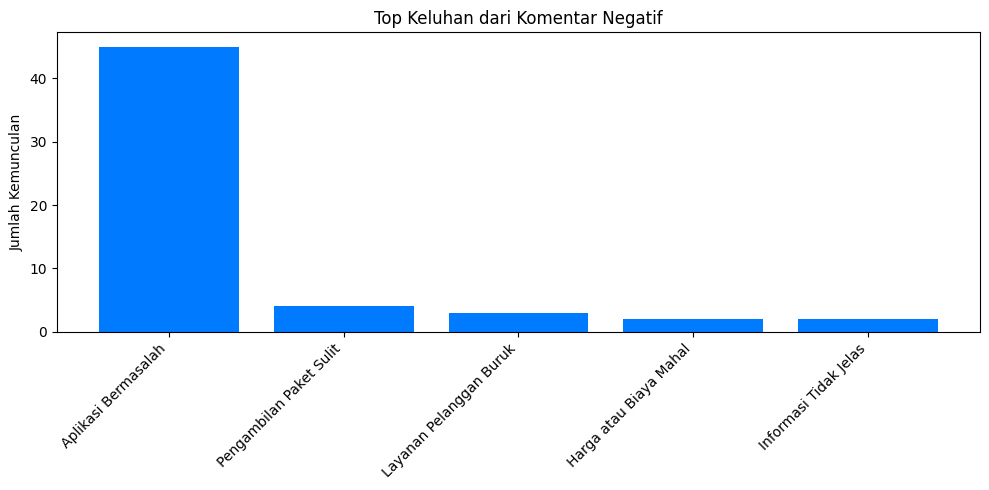

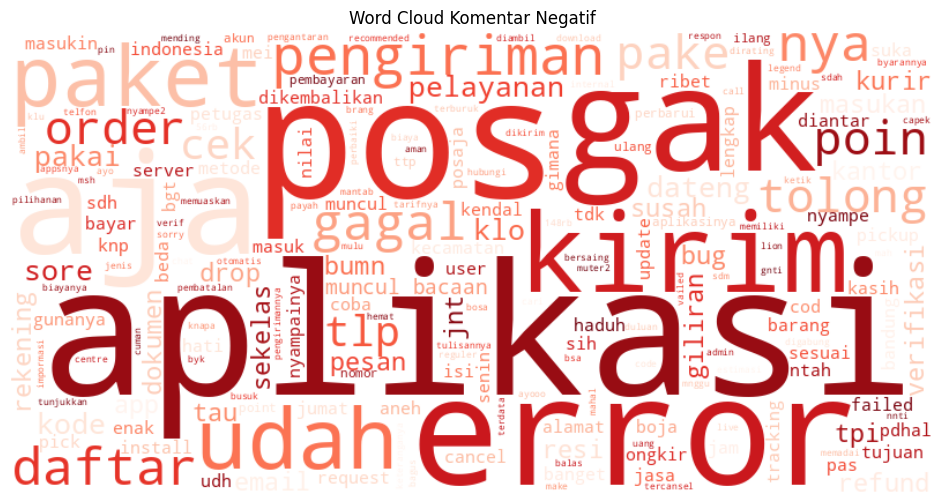

In [52]:
# Cell 3: Main execution (run after Cell 2)
app_id = 'com.posindonesia.cob'  # Post Indonesia app ID
print(f"Mengambil review untuk aplikasi dengan app_id: {app_id} ...")
reviews_list = scrape_reviews(app_id, count=1000)
print(f"Jumlah review yang diambil: {len(reviews_list)}")

df, complaint_counts, all_neg_words = analyze_and_categorize(reviews_list)

print(f"Total komentar: {len(df)}")
print(df['label'].value_counts())

print("\nTop Keluhan dari Komentar Negatif:")
for cat, count in complaint_counts.items():
    print(f"- {cat}: {count} kemunculan kata terkait")

plot_complaints(complaint_counts)
plot_wordcloud(all_neg_words)


The output you received from the bar chart indicates the frequency of specific complaint categories derived from negative reviews. Here’s a breakdown of the insights you can derive from the results:

Aplikasi Bermasalah: 5 kemunculan kata terkait: This indicates that users frequently mention issues related to the app itself, such as crashes, bugs, or functionality problems. This is a significant area of concern that needs to be addressed.

Harga atau Biaya Mahal: 2 kemunculan kata terkait: Users are also expressing concerns about the pricing or costs associated with the service. This could indicate that users feel the service is not providing value for the price.

Pengambilan Paket Sulit: 1 kemunculan kata terkait: There is a mention of difficulties in package retrieval, which could point to logistical issues or inefficiencies in the process.

In [12]:
def analyze_categorize_with_unique_users(reviews_list):
    sia = SentimentIntensityAnalyzer()
    data = []
    for rev in reviews_list:
        text = rev['content']
        user_id = rev['userName']  # Assuming 'userName' is the field for user ID
        sentiment = sia.polarity_scores(text)
        label = 'neutral'
        if sentiment['compound'] >= 0.05:
            label = 'positive'
        elif sentiment['compound'] <= -0.05:
            label = 'negative'
        data.append({'review': text, 'user_id': user_id, 'score': sentiment['compound'], 'label': label, 'at': rev['at']})
    df = pd.DataFrame(data)

    # Extract negative comments
    negative_reviews = df[df['label'] == 'negative']

    # Mapping from category to counts and unique user comments
    complaint_counts = {}
    complaint_examples = {}

    for cat, keywords in complaint_categories.items():
        count = 0
        unique_users = set()
        examples = []
        # Check each negative comment if it contains any category keyword
        for index, row in negative_reviews.iterrows():
            comment = row['review']
            user_id = row['user_id']
            if any(kw in comment for kw in keywords):
                count += 1
                unique_users.add(user_id)  # Track unique users
                if len(examples) < 3:  # Limit to 3 example comments per category
                    examples.append(comment)
        if count > 0:
            complaint_counts[cat] = count
            complaint_examples[cat] = examples

    complaint_counts = dict(sorted(complaint_counts.items(), key=lambda x: x[1], reverse=True))

    return df, complaint_counts, complaint_examples, len(unique_users)

# Example usage with existing scraped reviews:
df, complaint_counts, complaint_examples, unique_user_count = analyze_categorize_with_unique_users(reviews_list)

print(f"Total comments analyzed: {len(df)}")
print(f"Unique users providing negative feedback: {unique_user_count}")
print("Label counts:\n", df['label'].value_counts())
print("\nTop Complaints with Examples:\n")
for cat, count in complaint_counts.items():
    print(f"- {cat}: {count} comments related")
    print("  Examples:")
    for example in complaint_examples[cat]:
        print(f"    - {example}")
    print()


Total comments analyzed: 1000
Unique users providing negative feedback: 3
Label counts:
 label
neutral     873
positive     81
negative     46
Name: count, dtype: int64

Top Complaints with Examples:

- Aplikasi Bermasalah: 26 comments related
  Examples:
    - Biaya pengiriman sangat mahal dr aplikasi se jenis. estimasi pengiriman 4 hari tpi sdah 1 mnggu brang belum di antar, nnti ambil sendiri di drop poin. Pake Jnt di tujuan yg sama dr jnt byarannya 56rb tp pake pos aja biayanya 148rb. 😥😥😥😥😥
    - Ayo lah POS. Ini adalah BUMN besar dan legend. Aplikasi Pos aja terlalu sering error. Tunjukkan lah pos memiliki sdm yang memadai.
    - kenapa ya saya masukin pin tulisannya request gagal, internal server error, begitu terus

- Layanan Pelanggan Buruk: 5 comments related
  Examples:
    - Pengirimannya lama banget, padahal sekelas reguler tapi paket masih muter2 aja gak nyampe2, malah duluan nyampe jasa pengiriman yang lain padahal paket hemat. Sorry pelayanan anda kurang memuaskan klo bi

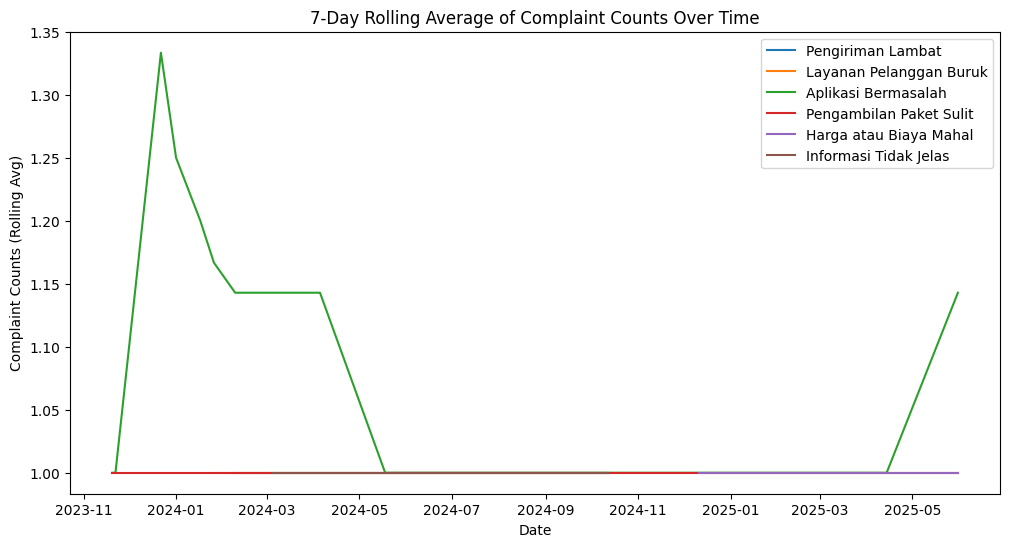

=== Predicted Complaint Trends & Recommendations ===
- Complaints related to 'Pengiriman Lambat' are stable or decreasing. Continue monitoring but current measures seem effective.
- Complaints related to 'Layanan Pelanggan Buruk' are stable or decreasing. Continue monitoring but current measures seem effective.
- Complaints related to 'Aplikasi Bermasalah' are stable or decreasing. Continue monitoring but current measures seem effective.
- Complaints related to 'Pengambilan Paket Sulit' are stable or decreasing. Continue monitoring but current measures seem effective.
- Complaints related to 'Harga atau Biaya Mahal' are stable or decreasing. Continue monitoring but current measures seem effective.
- Complaints related to 'Informasi Tidak Jelas' are stable or decreasing. Continue monitoring but current measures seem effective.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime

# Assume df (comments dataframe) has 'at' (datetime), 'label', 'review', and complaint categories info

# First, convert 'at' to datetime if not already done
df['at'] = pd.to_datetime(df['at'])

# Create a dataframe of negative comments with complaint categories
# For simplicity, assume you have a dict `complaint_examples` from before and `complaint_counts`

# We create a daily count per complaint category
def count_complaints_over_time(df, complaint_categories, window_days=7):
    records = []
    for cat, keywords in complaint_categories.items():
        cat_mask = df.apply(lambda row: row['label'] == 'negative' and any(kw in row['review'] for kw in keywords), axis=1)
        df_cat = df[cat_mask]
        if df_cat.empty:
            continue
        counts_by_date = df_cat.groupby(df_cat['at'].dt.date).size()
        for date, count in counts_by_date.items():
            records.append({'date': pd.to_datetime(date), 'category': cat, 'count': count})
    trend_df = pd.DataFrame(records)
    return trend_df

trend_df = count_complaints_over_time(df, complaint_categories)

# Plot complaint trends over time
plt.figure(figsize=(12,6))
for cat in trend_df['category'].unique():
    subset = trend_df[trend_df['category'] == cat].sort_values('date')
    plt.plot(subset['date'], subset['count'].rolling(window=7,min_periods=1).mean(), label=cat)
plt.title('7-Day Rolling Average of Complaint Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Complaint Counts (Rolling Avg)')
plt.legend()
plt.show()

# Predict next week's trend using linear regression for each category
def predict_trend(trend_df, days_ahead=7):
    preds = {}
    for cat in trend_df['category'].unique():
        subset = trend_df[trend_df['category'] == cat].sort_values('date')
        # Encode dates as ordinal for regression
        X = subset['date'].map(datetime.datetime.toordinal).values.reshape(-1,1)
        y = subset['count'].values
        if len(X) < 2:  # Not enough data for prediction
            preds[cat] = None
            continue
        model = LinearRegression()
        model.fit(X, y)
        future_dates = np.array([(subset['date'].max() + pd.Timedelta(days=i)).toordinal() for i in range(1, days_ahead+1)]).reshape(-1,1)
        y_pred = model.predict(future_dates)
        trend = 'increasing' if y_pred[-1] > y[-1] else 'decreasing or stable'
        preds[cat] = {'prediction': y_pred, 'trend': trend}
    return preds

predictions = predict_trend(trend_df)

# Prescriptive insights generation
def generate_prescriptive_recommendations(predictions):
    recommendations = []
    for cat, info in predictions.items():
        if info is None:
            rec = f"Data for category '{cat}' is insufficient for trend prediction."
        elif info['trend'] == 'increasing':
            rec = f"Complaints related to '{cat}' are predicted to increase. Recommend prioritizing issue investigation and deploying fixes or communication plans."
        else:
            rec = f"Complaints related to '{cat}' are stable or decreasing. Continue monitoring but current measures seem effective."
        recommendations.append(rec)
    return recommendations

recommendations = generate_prescriptive_recommendations(predictions)

# Display prescriptive recommendations
print("=== Predicted Complaint Trends & Recommendations ===")
for rec in recommendations:
    print("-", rec)


=== Prescriptive Recommendations ===

1. Aplikasi Bermasalah (Increasing Complaints):
   - Investigate specific issues causing complaints.
   - Implement a user feedback loop for real-time reporting.
   - Prepare a communication plan to inform users about ongoing investigations.
   - Schedule regular updates to address bugs and improve functionality.

2. Pengambilan Paket Sulit (Stable or Decreasing Complaints):
   - Continue monitoring user feedback to ensure effectiveness.
   - Conduct user interviews or surveys for deeper insights.
   - Encourage satisfied users to leave positive reviews.
   - Keep users informed about improvements made in this area.

3. Harga atau Biaya Mahal (Insufficient Data):
   - Gather more data through targeted surveys on pricing.
   - Conduct a competitive analysis of pricing.
   - Consider promotional offers or discounts to improve satisfaction.
   - Provide clear information about the value of services to justify pricing.

4. Informasi Tidak Jelas (Unclear Information)
    - Training: Train customer service staff to improve responsiveness and problem resolution.
    - Support Channels: Introduce multi-channel support (chat, phone, email) with faster response times.
    - Quality: Conduct quality monitoring to evaluate support interactions.
    - Feedback: Collect customer feedback regularly to identify areas for service improvement.

5. Informasi Tidak Jelas (Unclear Information)
    - UI/UX: Improve the user interface to provide clearer tracking information and status updates.
    - Bug Fixes: Promptly fix bugs affecting tracking, voucher usage, and order/refund visibility.
    - Education: Provide tutorials or a help section to educate users about app features and procedures.
    - Reliability: Ensure timely updates and maintenance to enhance app reliability and user trust.